Loading and preprocessing data...
Shape of the preprocessed data: (2947, 16)

First few rows of the preprocessed data:
  Month Date SL Geounit (Code) SL Sub Geounit (Code)  \
0 2021-12-01               NAO                   NGC   
1 2022-01-01               ECP                   COL   
2 2022-01-01               ECP                   COL   
3 2022-01-01               ECP                   COL   
4 2022-01-01               ECP                   COL   

  SL Sub Business Line (Code)            Rig Name                  Well Name  \
0                        WLES    DEEPWATER PONTUS  OCS-G08852 KE002 ST00BP00   
1                        WLES       ESTRELLA 2027              FLORENA TP-12   
2                        WLES  IESCO T - 645 XT39             RUBIALES 1776H   
3                        WLES  IESCO T - 645 XT39             RUBIALES 1984H   
4                        WLES     INDEPENDENCE 50                  CIRA 3898   

                               Customer Account Name  \
0  SWEP

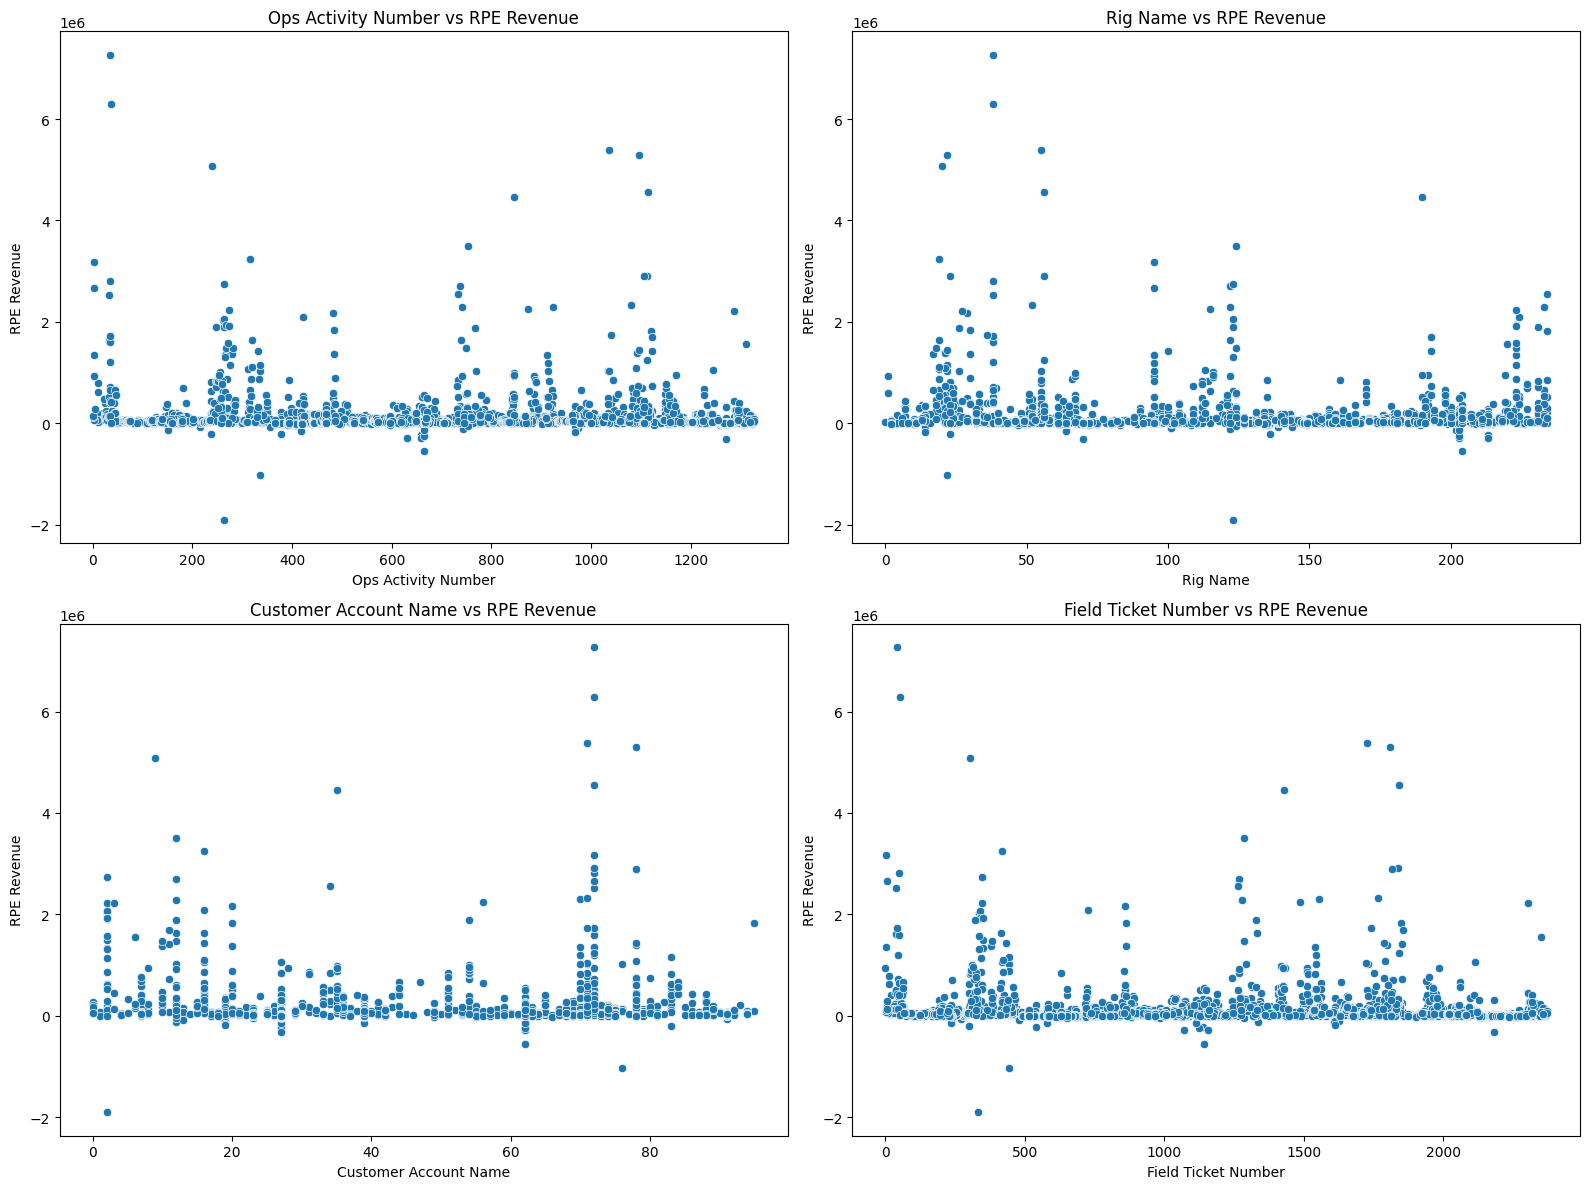


Preprocessing and feature selection completed.


In [1]:
# 08_rpe_revenue_preprocessing_and_feature_selection.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from catboost import CatBoostRegressor, Pool
import sys
from pathlib import Path

# Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from utils.revenue_data_preprocessing import preprocess_rpe_data

# Set up matplotlib for inline plotting
%matplotlib inline

# 1. Load and preprocess the data
print("Loading and preprocessing data...")
rpe_df = pd.read_csv('../raw_data/global_rpe_revenue.csv')
rpe_df = preprocess_rpe_data(rpe_df)

print("Shape of the preprocessed data:", rpe_df.shape)
print("\nFirst few rows of the preprocessed data:")
print(rpe_df.head())

# 2. Perform exploratory data analysis (EDA)
print("\nData types:")
print(rpe_df.dtypes)

print("\nMissing values:")
print(rpe_df.isnull().sum())

print("\nSummary statistics:")
print(rpe_df.describe())

# 3. Handle missing values and encode categorical variables
categorical_columns = rpe_df.select_dtypes(include=['object']).columns
rpe_df[categorical_columns] = rpe_df[categorical_columns].fillna('Unknown')

# Encode categorical variables
le = LabelEncoder()
for col in categorical_columns:
    rpe_df[col] = le.fit_transform(rpe_df[col])

# 4. Implement automated feature selection
def select_features(X, y, max_features=4):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    selected_features = mi_scores.head(max_features).index.tolist()
    return selected_features

# Prepare features and target
X = rpe_df.drop(['Month Date', 'RPE Revenue'], axis=1)
y = rpe_df['RPE Revenue']

# Select the best features
best_features = select_features(X, y, max_features=4)
print("\nBest selected features:")
print(best_features)

# 5. Prepare the data for the CatBoost model
X_selected = rpe_df[best_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 6. Save the preprocessed data and selected features
preprocessed_data = pd.concat([X_selected, y], axis=1)
preprocessed_data.to_csv('../processed_data/preprocessed_rpe_revenue.csv', index=False)

print("\nPreprocessed data saved to: ../processed_data/preprocessed_rpe_revenue.csv")

# Visualize the relationship between selected features and target variable
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(best_features):
    sns.scatterplot(data=preprocessed_data, x=feature, y='RPE Revenue', ax=axes[i])
    axes[i].set_title(f'{feature} vs RPE Revenue')

plt.tight_layout()
plt.show()

print("\nPreprocessing and feature selection completed.")